In [3]:
import os
import csv
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
import matplotlib.pyplot as plt
from darts.metrics import mape, mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, BlockRNNModel, NBEATSModel, XGBModel, LightGBMModel, RandomForest, LinearRegressionModel
from sklearn.ensemble import RandomForestRegressor

ORIGINAL_DATA_PATH = os.getcwd() + '/../data/Fundamental+Technical Data/STOCK_DATA/'
DATA_PATH = os.getcwd() + '/../data/Fundamental+Technical Data/STOCK_DATA_WEEKLY/'
LDA_NEWS_PATH = os.getcwd() + '/../data/Online Data/LDA News/News.csv'
LDA_TWITTER_PATH = os.getcwd() + '/../data/Online Data/LDA Twitter/Twitter.csv'
GDELT_V1_PATH = os.getcwd() + '/../data/Online Data/GDELT V1/gdelt_v1.csv'
GDELT_V2_PATH = os.getcwd() + '/../data/Online Data/GDELT V2/gdelt_v2.csv'
ID_PATH = os.getcwd() + '/../data/Fundamental+Technical Data/ID_Name.csv'
RESULT_PATH = os.getcwd() + '/../result/'
PARAMETER_PATH = os.getcwd() + '/../model/'
FOCUS_COMPONENT = 'Close'
RETAIN_COMPONENTS = ["Open", "High", "Low", "PE", "PBV", "T_EPS", "FSCORE", "Vol",
                           "Buy Vol", "Sell Vol", "ATO/ATC", "EMA25", "EMA50", "EMA200", "MACD", "RSI"]
TRAINING_SIZE = 139
VALIDATE_SIZE = 35
TEST_SIZE = 35
PREDICT_SIZE = 1
STOCK_LIST = ["ADVANC", "BANPU", "BH", "BTS", "CBG", "CPALL", "CPF", "INTUCH", "IVL", "KBANK", "LH", "PTT", "PTTEP", "PTTGC", "SCB", "SCC", "TISCO", "TU", "WHA"]

def load_data(stock_name):
    stock_data = pd.read_csv(os.path.join(DATA_PATH, (stock_name + ".csv")))
    id_name_map = pd.read_csv(ID_PATH)
    stock_id = id_name_map.loc[id_name_map['Stock_Name'].str.strip() == stock_name, 'Stock_ID'].iloc[0]
    industry_name = id_name_map.loc[id_name_map['Stock_Name'].str.strip() == stock_name, 'Industry_Name'].iloc[0]
    lda_news_df = pd.read_csv(LDA_NEWS_PATH)
    prefix = "news"
    lda_news_df.columns =  [f"{prefix}_{col}" if col != 'Date' else col for col in lda_news_df.columns]
    lda_twitter_df = pd.read_csv(LDA_TWITTER_PATH)
    prefix = "twitter"
    lda_twitter_df.columns =  [f"{prefix}_{col}" if col != 'Date' else col for col in lda_twitter_df.columns]
    GDELTv1 = pd.read_csv(GDELT_V1_PATH)
    prefix = "gdeltv1"
    GDELTv1.columns =  [f"{prefix}_{col}" if col != 'Date' else col for col in GDELTv1.columns]
    GDELTv2 = pd.read_csv(GDELT_V2_PATH)
    prefix = "gdeltv2"
    GDELTv2.columns =  [f"{prefix}_{col}" if col != 'Date' else col for col in GDELTv2.columns]
    data_df = stock_data.copy()
    return stock_data, stock_id, data_df, lda_news_df, lda_twitter_df, GDELTv1, GDELTv2

def limit_column_name_length(df, max_length):
    truncated_columns = {col: col[:max_length] for col in df.columns}
    df.rename(columns=truncated_columns, inplace=True)
    return df

def preprocess_online_data(data_df, online_data_df):
    if 'Date' in data_df.columns:
        data_df['Date'] = pd.to_datetime(data_df['Date'])
        data_df.set_index('Date', inplace=True)

    online_data_df['Date'] = pd.to_datetime(online_data_df['Date'])
    online_data_df.set_index('Date', inplace=True)
    
    # Remove news data after the last date in data_df
    last_data_date = data_df.index.max()
    online_data_df = online_data_df[online_data_df.index <= last_data_date]
    
    summed_df = pd.DataFrame(index=data_df.index.unique()).sort_index()
    summed = online_data_df.reindex(summed_df.index, method='ffill').fillna(0)
    summed_df = pd.concat([summed_df, summed], axis=1)
    summed_df.reset_index(inplace=True)

    return summed_df

def preprocess_data(data, data_df,  lda_news_df, lda_twitter_df, GDELTv1, GDELTv2, split, features):
    data = data.dropna()
    serie = data[FOCUS_COMPONENT]
    past_covariate = data[RETAIN_COMPONENTS].apply(pd.to_numeric, errors='coerce').ffill().bfill()
    
    if 2 in features:
        updated_lda_news_df = preprocess_online_data(data_df, lda_news_df)
        past_covariate = past_covariate.join(updated_lda_news_df.reset_index(drop=True).drop(columns='Date'))

    if 3 in features:
        updated_lda_twitter_df = preprocess_online_data(data_df, lda_twitter_df)
        past_covariate = past_covariate.join(updated_lda_twitter_df.reset_index(drop=True).drop(columns='Date'))

    if 4 in features:
        updated_GDELTv1 = preprocess_online_data(data_df, GDELTv1)
        past_covariate = past_covariate.join(updated_GDELTv1.reset_index(drop=True).drop(columns='Date'))

    if 5 in features:
        updated_GDELTv2 = preprocess_online_data(data_df, GDELTv2)
        past_covariate = past_covariate.join(updated_GDELTv2.reset_index(drop=True).drop(columns='Date'))

    past_covariate = limit_column_name_length(past_covariate, 10)

    serie_ts = TimeSeries.from_dataframe(serie.to_frame())
    past_cov_ts = TimeSeries.from_dataframe(past_covariate)
    scaler = StandardScaler()
    scaler_dataset = Scaler(scaler)
    scaled_serie_ts = scaler_dataset.fit_transform(serie_ts)
    if split == 0:
        training_scaled = scaled_serie_ts
    else:
        training_scaled = scaled_serie_ts[:-split]
        past_cov_ts = past_cov_ts[:-split]
    
    return training_scaled, past_cov_ts, scaler_dataset

def predict_next_n_days(model, training_scaled, past_cov_ts, scaler_dataset):
    model.fit(training_scaled, past_covariates=past_cov_ts)
    forecast = model.predict(PREDICT_SIZE)
    in_forecast = scaler_dataset.inverse_transform(forecast)
    return in_forecast

model = LinearRegressionModel(lags=10,lags_past_covariates=6,output_chunk_length=1)
# model = TransformerModel(input_chunk_length=1,n_epochs=15,output_chunk_length=1)
stock_data, stock_id, data_df, lda_news_df, lda_twitter_df, GDELTv1, GDELTv2 = load_data('ADVANC')
training_scaled, past_cov_ts, scaler_dataset = preprocess_data(stock_data, data_df, lda_news_df, lda_twitter_df, GDELTv1, GDELTv2, 70, [1,3,4])
predictions = predict_next_n_days(model, training_scaled, past_cov_ts, scaler_dataset)
round(predictions.values()[0][0],2)

218.75

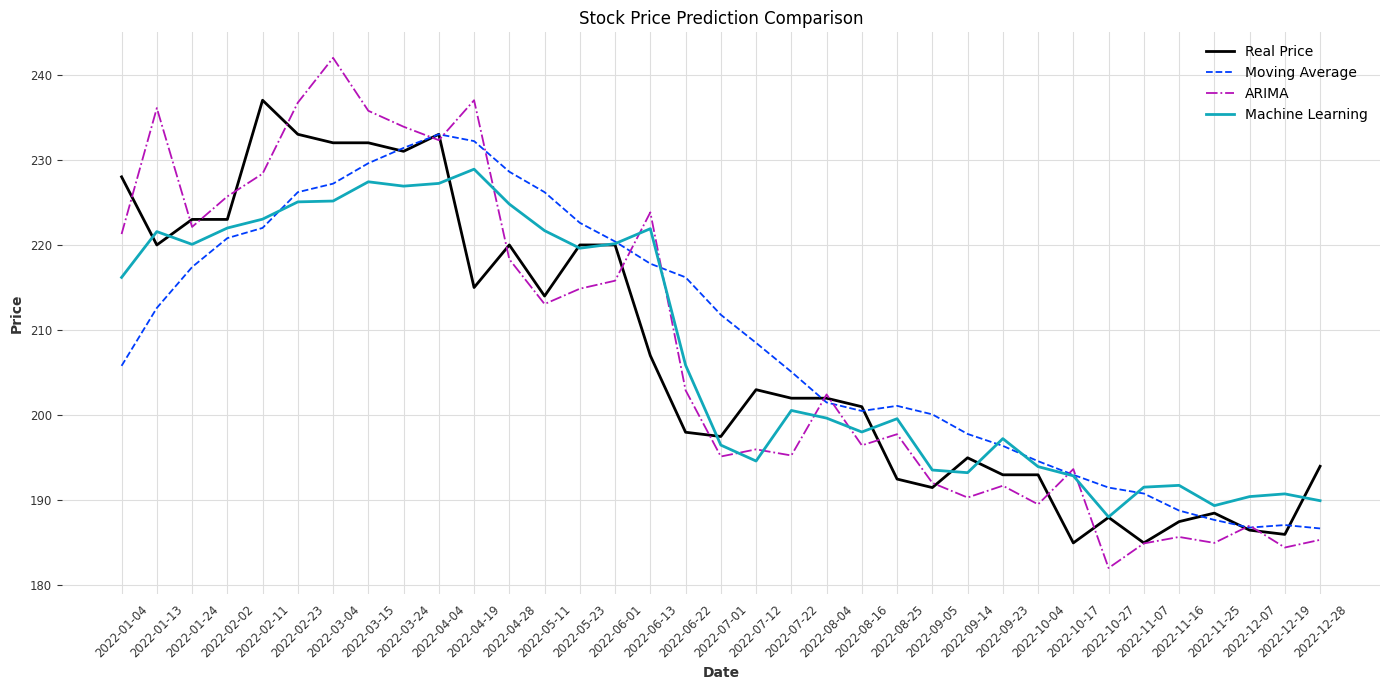

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Paths to your CSV files
real_price_path = '/data1-8tb-blk/sp2023stock/Insight-Wave/StockPrediction/data/Fundamental+Technical Data/STOCK_DATA_WEEKLY/ADVANC.csv'
moving_average_path = '/data1-8tb-blk/sp2023stock/Insight-Wave/StockPrediction/model/ADVANC/Moving Average/window_size_5.csv'
arima_path = '/data1-8tb-blk/sp2023stock/Insight-Wave/StockPrediction/model/ADVANC/ARIMA/ARIMA_d4_p10_q2.csv'
machine_learning_path = '/data1-8tb-blk/sp2023stock/Insight-Wave/StockPrediction/model/ADVANC/Fundamental+LDA News+LDA Twitter+GDELT V1+GDELT V2/RandomForest_lags10_lags_past_covariates2_output_chunk_length1.csv'

# Reading CSV files
real_price_df = pd.read_csv(real_price_path)
real_price_df = real_price_df.iloc[-70:-35]
moving_average_df = pd.read_csv(moving_average_path)
arima_df = pd.read_csv(arima_path)
machine_learning_df = pd.read_csv(machine_learning_path)

# Assuming there's a common 'Date' column for merging/joining or plotting
# If there's no 'Date' column, you'll need to adjust the x-axis accordingly
plt.figure(figsize=(14, 7))

# Plotting
plt.plot(real_price_df['Date'], real_price_df['Close'], label='Real Price', linewidth=2)
plt.plot(moving_average_df['Date'], moving_average_df['Closing_Price'], label='Moving Average', linestyle='--')
plt.plot(arima_df['Date'], arima_df['Closing_Price'], label='ARIMA', linestyle='-.')
plt.plot(machine_learning_df['Date'], machine_learning_df['Closing_Price'], label='Machine Learning', linewidth=2)

# Customizing the plot
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.legend()
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
import shutil
src = "/no logic model/ADVANC/Fundamental+GDELT V1/BlockRNNModel_input_chunk_length1_modelLSTM_n_epochs15_output_chunk_length1.csv"
dst = "/model"
shutil.copyfile(src, dst)

In [1]:
def calculate_directional_accuracy(actual, forecast):  
    acc = 0
    for i in range(len(forecast)):
        actual_change = actual[i + 1] - actual[i]
        predicted_change = forecast[i] - actual[i]
        if (actual_change > 0 and predicted_change > 0) or (actual_change < 0 and predicted_change < 0) or (actual_change == 0 and predicted_change == 0):
            acc += 1

    da = round(acc / len(forecast) * 100, 2)
    return da

def calculate_directional_accuracy_with_thresholds(actual, forecast):
    thresholds = [0, 5, 10] 
    combinations = [(up, -down) for up in thresholds for down in thresholds if not (up > 0 and down > 0)]
    results = []
    for up, down in combinations:
        acc = 0
        for i in range(len(forecast)):
            actual_change = ((actual[i + 1] - actual[i]) / actual[i]) * 100
            predicted_change = ((forecast[i] - actual[i]) / actual[i]) * 100
            if (actual_change > up and predicted_change > up) or \
                (actual_change < down and predicted_change < down) or\
                (actual_change == predicted_change):
                acc += 1

        da = round(acc / len(forecast) * 100, 2)
        results.append((up, down, da))
    
    return results

def calculate_mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    non_zero_actual = np.where(actual == 0, np.nan, actual)
    mape = np.mean(np.abs((actual - forecast) / non_zero_actual)) * 100
    return np.nanmean(mape)

def calculate_rmse(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    if len(actual) != len(forecast):
        raise ValueError("The length of actual and forecast arrays must match.")
    mse = np.mean((forecast - actual) ** 2)
    return np.sqrt(mse)

def cal_err_and_acc(predicted_ts, val_ts, condition=True):
    val = val_ts.pd_dataframe()
    predicted = predicted_ts.pd_dataframe()

    val.reset_index(drop=True, inplace=True)
    predicted.reset_index(drop=True, inplace=True)

    actual = val['Close']
    forecast = predicted['Closing_Price']
    
    mape_error = calculate_mape(actual.iloc[1:], forecast)
    rmse_error = calculate_rmse(actual.iloc[1:], forecast)
    dir_acc = calculate_directional_accuracy_with_thresholds(actual, forecast)
    
    if condition:
        return mape_error, rmse_error, dir_acc
    else:
        print(f"MAPE = {mape_error:.2f} %")
        print(f"RMSE = {rmse_error:.2f} %\n")
        print(f"Directional Accuracy = {dir_acc:.2f} %")

In [5]:
import os
import csv
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import ARIMA
import matplotlib.pyplot as plt
from darts.metrics import mape, mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from darts.dataprocessing.transformers import Scaler
from darts.models import TiDEModel, BlockRNNModel, NBEATSModel, XGBModel, RegressionModel, LinearRegressionModel, RandomForest

In [23]:
stock = "CBG"
arima_predict = pd.read_csv(f"/data1-8tb-blk/sp2023stock/Insight-Wave/StockPrediction/backtest/{stock}/ARIMA.csv")
arima_predict_ts = TimeSeries.from_dataframe(arima_predict[['Closing_Price']], time_col=None)
ins_predict = pd.read_csv(f"/data1-8tb-blk/sp2023stock/Insight-Wave/StockPrediction/backtest/{stock}/InsightWave.csv")
ins_predict_ts = TimeSeries.from_dataframe(ins_predict[['Closing_Price']], time_col=None)
val = pd.read_csv(f"/data1-8tb-blk/sp2023stock/Insight-Wave/StockPrediction/data/Fundamental+Technical Data/STOCK_DATA_WEEKLY/{stock}.csv")
val = val[['Close']].iloc[-35-1:]
val_ts = TimeSeries.from_dataframe(val, time_col=None)
arima_avg_mape, arima_avg_rmse, arima_avg_dir = cal_err_and_acc(arima_predict_ts, val_ts, True)
ins_avg_mape, ins_avg_rmse, ins_avg_dir = cal_err_and_acc(ins_predict_ts, val_ts, True)
print(f"ARIMA : MAPE {round(arima_avg_mape,2)}, RSME {round(arima_avg_rmse,2)}")
print(f"InsightWave : MAPE {round(ins_avg_mape,2)}, RSME {round(ins_avg_rmse,2)}")

ARIMA : MAPE 5.03, RSME 4.82
InsightWave : MAPE 5.38, RSME 5.06
